In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import sys
import os

sys.path.insert(0, os.path.abspath("../.."))
sys.path.append(os.path.abspath("../../backend"))
sys.path.append(os.path.abspath(""))

from sqlalchemy.orm import aliased, joinedload, selectinload, contains_eager
from sqlalchemy import text
from rdflib.plugins.stores.sparqlstore import SPARQLStore
from backend.model import (
    DeclarativeBase,
    Session,
)

from backend.ontology import OntologyManager, OntologyConfig, Graph
from backend.explorative.explorative_support import GuidanceManager, select
from backend.explorative.llm_query import (
    Entity,
    Relation,
    EntitiesRelations,
    EnrichedEntitiesRelations,
)
from backend.explorative.llm_query_gen import choose_graph
from tqdm import tqdm
import pandas as pd

from backend.eval_config import DBPEDIA_CONFIGS, OMA_CONFIGS, SelectionDistribution, EvalConfig

# db_setups = [DBPEDIA_CONFIGS[1], OMA_CONFIGS[1]]
db_setups = [DBPEDIA_CONFIGS[-1]]
setup=db_setups[0]
print("Generating for ", setup.name)
store = SPARQLStore(
    setup.sparql_endpoint,
    method="POST_FORM",
    params={"infer": False, "sameAs": False},
)
graph = Graph(store=store)

config = OntologyConfig()

ontology_manager = OntologyManager(config, graph)
topic_man = GuidanceManager(
    ontology_manager,
    llm_model_id=setup.model_id,
    conn_str=setup.conn_str,
)
llama_model = topic_man.llama_model

Generating for  DBpedia
Loading LLM model NousResearch/Hermes-3-Llama-3.2-3B-GGUF None


ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 4090, compute capability 8.9, VMM: yes
llama_model_load_from_file_impl: using device CUDA0 (NVIDIA GeForce RTX 4090) - 23528 MiB free
llama_model_loader: loaded meta data with 38 key-value pairs and 255 tensors from /home/bkantz/.cache/huggingface/hub/models--NousResearch--Hermes-3-Llama-3.2-3B-GGUF/snapshots/3cd927095d8cbab12c743f932aa63b6f7bbfa141/./Hermes-3-Llama-3.2-3B.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Hermes 3 Llama 3.2 3b Base Fft Chatml...
llama

In [4]:
top_k = 100
seed = 42

In [5]:
from typing import TypeVar

SL = TypeVar("SL")


erl: EnrichedEntitiesRelations = choose_graph(
    seed=2, max_nodes=10, topic_man=topic_man, max_tries=10
)

In [6]:
[(link.entity, link.relation, link.target) for link in erl.relations]

[('work', 'starring', 'actor'),
 ('work', 'auteur', 'person'),
 ('sports team 4', 'current member', 'person'),
 ('television show', 'presenter', 'person'),
 ('political function', 'person', 'person'),
 ('movie 7', 'film director', 'person'),
 ('sports team 8', 'manager', 'person'),
 ('work', 'publisher', 'agent'),
 ('movie 10', 'editing', 'person')]

In [7]:
erl.entities[0].model_dump_json()

'{"identifier":"work","type":"work","constraints":[],"subject":{"subject_id":"<http://dbpedia.org/ontology/Work>","label":"work","spos":{"rdf:type":{"property":"rdf:type","label":null,"values":[{"value":"owl:Class","label":null}]},"rdfs:label":{"property":"rdfs:label","label":null,"values":[{"value":"work","label":null}]},"rdfs:subClassOf":{"property":"rdfs:subClassOf","label":null,"values":[{"value":"owl:Thing","label":null}]}},"subject_type":"class","refcount":0,"descendants":{},"total_descendants":0,"properties":{},"instance_count":623392}}'

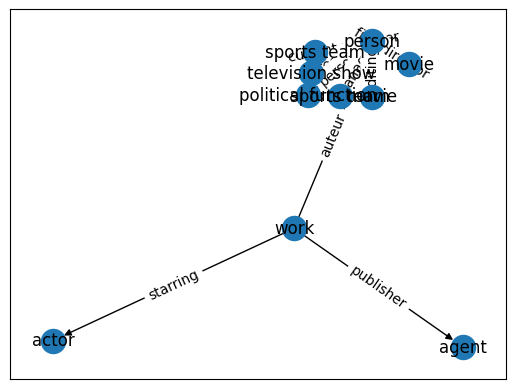

In [8]:
import networkx as nx


def viz_graph(erl: EnrichedEntitiesRelations):
    G = nx.DiGraph()
    for node in erl.entities:
        G.add_node(node.identifier, label=node.type)
    for link in erl.relations:
        G.add_edge(
            link.entity,
            link.target,
            # weight=link.link.instance_count,
            label=link.relation,
        )
    pos = nx.spring_layout(G)
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        labels={node.identifier: node.type for node in erl.entities},
    )
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels={
            (link.entity, link.target): link.relation for link in erl.relations
        },
    )
    return G


viz_graph(erl)

In [9]:
messages = [
    {
        "role": "system",
        "content": """"You are a helpful assistant turning relational knowledge into natural language queries. Use the type as the identifier!""",
    },
    {
        "role": "user",
        "content": EntitiesRelations(
            entities=[
                Entity(
                    identifier="person 1",
                    type="person",
                ),
                Entity(
                    identifier="place 1",
                    type="place",
                ),
                Entity(
                    identifier="company 1",
                    type="person",
                ),
            ],
            relations=[
                Relation(
                    entity="company 1",
                    relation="employs",
                    target="person 1",
                ),
                Relation(
                    entity="person 1",
                    relation="residence",
                    target="place 1",
                ),
            ],
        ).model_dump_json(),
    },
    {
        "role": "assistant",
        "content": "a person is employed by a company and the same person resides in a place",
    },
]


In [10]:
response = llama_model.create_chat_completion(
    # grammar=self.grammar_erl,
    messages=messages + [
        {
            "role": "user",
            "content": erl.model_dump_json(),
        }
    ],
    max_tokens=-1,
    temperature=0.7,  # get wild :)
)


llama_perf_context_print:        load time =     505.59 ms
llama_perf_context_print: prompt eval time =     504.56 ms /  5391 tokens (    0.09 ms per token, 10684.66 tokens per second)
llama_perf_context_print:        eval time =     375.93 ms /    63 runs   (    5.97 ms per token,   167.58 tokens per second)
llama_perf_context_print:       total time =     913.76 ms /  5454 tokens


In [11]:
response["choices"][0]["message"]["content"]

'The work is related to an actor and a television show, and the same person is a current member of a sports team and a film director. The person is also the auteur of a work and the editing team of a movie. Additionally, the work was published by an agent and managed by a sports team.'

In [12]:
n_examples = 300
n_nodes = [3, 5, 10]
resulting_examples = []
progress = tqdm(total=n_examples * len(n_nodes))
for n_node in n_nodes:
    for i in range(n_examples):
        
        erl = choose_graph(seed=i, max_nodes=n_node, topic_man=topic_man)
        response = llama_model.create_chat_completion(
            # grammar=self.grammar_erl,
            messages=messages
            + [
                {
                    "role": "user",
                    "content": erl.model_dump_json(),
                }
            ],
            max_tokens=-1,
            temperature=0.7,  # get wild :)
        )
        progress.update(1)
        resulting_examples.append(
            {
                "erl": erl.model_dump_json(),
                "response": response["choices"][0]["message"]["content"],
                "n_nodes": n_node,
                "seed": i,
            }
        )
        topic_man.engine.dispose()
        
resulting_examples_df = pd.DataFrame(resulting_examples)
resulting_examples_df.to_csv("llama_examples.csv")

  0%|          | 0/900 [00:00<?, ?it/s]

Llama.generate: 147 prefix-match hit, remaining 1339 prompt tokens to eval
llama_perf_context_print:        load time =     505.59 ms
llama_perf_context_print: prompt eval time =      77.96 ms /  1339 tokens (    0.06 ms per token, 17176.36 tokens per second)
llama_perf_context_print:        eval time =      95.62 ms /    18 runs   (    5.31 ms per token,   188.25 tokens per second)
llama_perf_context_print:       total time =     183.41 ms /  1357 tokens
  0%|          | 1/900 [00:00<07:29,  2.00it/s]Llama.generate: 147 prefix-match hit, remaining 1334 prompt tokens to eval
llama_perf_context_print:        load time =     505.59 ms
llama_perf_context_print: prompt eval time =      77.66 ms /  1334 tokens (    0.06 ms per token, 17176.78 tokens per second)
llama_perf_context_print:        eval time =     116.83 ms /    22 runs   (    5.31 ms per token,   188.32 tokens per second)
llama_perf_context_print:       total time =     206.46 ms /  1356 tokens
  0%|          | 2/900 [00:00<06:

KeyboardInterrupt: 

In [ ]:
resulting_examples

[{'erl': '{"relations":[{"entity":"Organisation member","relation":"death place","target":"stream","link":{"link_id":54010,"label":"death place","from_id":"<http://dbpedia.org/ontology/OrganisationMember>","link_type":"owl:ObjectProperty","to_id":"<http://dbpedia.org/ontology/Stream>","to_proptype":null,"property_id":"<http://dbpedia.org/ontology/deathPlace>","from_subject":{"subject_id":"<http://dbpedia.org/ontology/OrganisationMember>","label":"Organisation member","spos":{"rdf:type":{"property":"rdf:type","label":null,"values":[{"value":"owl:Class","label":null}]},"rdfs:label":{"property":"rdfs:label","label":null,"values":[{"value":"Organisation member","label":null}]},"rdfs:subClassOf":{"property":"rdfs:subClassOf","label":null,"values":[{"value":"<http://dbpedia.org/ontology/Person>","label":"person"}]}},"subject_type":"class","refcount":0,"descendants":{},"total_descendants":0,"properties":{},"instance_count":456914},"to_subject":{"subject_id":"<http://dbpedia.org/ontology/Strea

: 